# Experiment 5: Indirect-contrl ZNE with noise-free Ising time-evolution gate
---

This experiment is:

- Qubit: 7, layer: 30
- System has noise-free time evolution.
- Target observable: Transverse field Ising Hamiltonian.
- Ansatz time-evolution: Ising-Hamiltonian.

## (1) Imports and setup

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

In [2]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 11
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 10

In [3]:
plot_titles = ["Ising ansatz", "Expectation value vs noise level, Ising ansatz"]
plot_color = ["green", "darkred", "darkblue", "darkgreen", "darkmagenta", "darkcyan", "goldenrod", "black", "orange", "purple"]

## (2) Loading experimental data

The raw experimental are available at `experimental data/data`.

**NOTE**: _JSON files are not appended in any specific order._

In [4]:
# Folder containing your JSON files
folder_path = "experimental data/data"

# List to store the data from the filtered JSON files
vqe_data = []
all_zne_data = []
noise_free_data = [] 

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".json") and "VQE" in filename:  
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as file:
            data = json.load(file)
            vqe_data.append(data)
    elif filename.endswith(".json") and "ZNE" in filename:
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as file:
            data = json.load(file)
            all_zne_data.append(data)
    elif filename.endswith(".json") and "renamed.noisefree_ising" in filename:
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as file:
            data = json.load(file)
            noise_free_data.append(data)

## (3) Extracting experimental outcomes

Now lets extract some useful informations.

### (A) Exact minimum eigen value

The exact minimum eigen value is recorded in `filenameprefix_VQE.json` under the key `exact_sol`.

In [5]:
exact_sol = vqe_data[0]["output"]["exact_sol"]
print(f"Exact sol: {exact_sol}")

Exact sol: -8.56677223350563


### (B) Noise-free ansatz data

We ran VQE by setting `ansatz.noise.status: False` in configuration to get noise-free estimations for the algorithm.

In [6]:
noisefree_estimation = noise_free_data[0]["output"]["optimized_minimum_cost"]
noisefree_mean = np.mean(noisefree_estimation)
noisefree_sd = np.std(noisefree_estimation)
print(f"Noise-free mean estimation: {noisefree_mean}")
print(f"Noise-free standard deviation: {noisefree_sd}")

Noise-free mean estimation: -7.508800972542149
Noise-free standard deviation: 0.20600450859363448


### (C) Unmitigated data from noisy standard ansatz

Unmitigated expectation values are recodred in `filenameprefix_VQE.json` file under the key `optimized_minimum_cost`.

In [7]:
unmitigated_eigen_vals = vqe_data[0]["output"]["optimized_minimum_cost"]
unmitigated_eigen_vals_mean = np.mean(unmitigated_eigen_vals)
unmitigated_eigen_vals_sd = np.std(unmitigated_eigen_vals)
print(f"Unmitigated noisy mean estimation: {unmitigated_eigen_vals_mean}")
print(f"Unmitigated noisy standard deviation: {unmitigated_eigen_vals_sd}")

Unmitigated noisy mean estimation: -5.922666733092577
Unmitigated noisy standard deviation: 0.2803031932996163


### (D) Noise-Boosted Redundant Ansatz Data

Two-point Richardson extrapolation was performed for ZNE. The noise levels at these two points were (6, 16), where the first value corresponds to the unboosted noise level and the second value represents the boosted noise level. These values are available in the ZNE data files (`somefilenameprefix_ZNE.json`) under the `sorted_noise` key.  

**How is noise boosted?**  

The noise level in the circuit is artificially boosted using _identity scaling_. For any noisy quantum gate $G$, a noisy identity $G^{\dagger}G$ is inserted into the circuit. The number of identities to be inserted is determined by the `identity_factors` specified in the configuration file.  

**WARNING:** _Identity scaling for time evolution works only when `ansatz.type: 'xy-iss'`._

**How are these noise levels calculated?**  

The noise level is a quantity proportional to the number of noisy gates in each layer of the ansatz. It is defined as `[nR, nT, nY, nCZ]`, where each value is proportional to the number of rotation gates, time-evolution gates, Pauli-Y gates, and CZ gates, respectively. These values, along with the corresponding energy estimations $E$, are available in the ZNE data files (`somefilenameprefix_ZNE.json`) under the `data_points` key as `[nR, nT, nY, nCZ, E]`.  

For multivariate extrapolation methods, such as `richardson-mul` or `polynomial`, `[nR, nT, nY, nCZ]` are treated as independent variables, with the corresponding energy value `E` serving as the dependent variable. In contrast, for `richardson`, a univariate method, the noise level is defined as the sum: `sum(nR, nT, nY, nCZ)`.  

In [8]:
boosted_noisy_expectation_list = []  # Stores the expectation values corresponding to noise level 16 (boosted form 6 to 16)

for data in all_zne_data:
    boosted_noisy_expectation_vals = data["output"]["zne_values"]["others"]["sorted_expectation_vals"][-1]  # List containing expectation values [val1, val2] for noise levels 6 and 16.
    boosted_noisy_expectation_list.append(boosted_noisy_expectation_vals)

boosted_noisy_expectation_val_mean = np.mean(boosted_noisy_expectation_list)    # Mean expected value at boosted noise 16
boosted_noisy_expectation_val_sd = np.std(boosted_noisy_expectation_list)

# Printing the means and standard deviations
print(f"Mean expectation value at noise level 16: {boosted_noisy_expectation_val_mean}")
print(f"Standard deviation at noise level 16: {boosted_noisy_expectation_val_sd}")


Mean expectation value at noise level 16: -3.6510215069160545
Standard deviation at noise level 16: 0.2705058563695829


### (E) ZNE data: Mean and standard deviation of ZNE values

The result of ZNE error mitigation by 2-point Richardson extrapolation.

In [9]:
zne_vals = []
for data in all_zne_data:
    zne_val = data["output"]["zne_values"]["extrapolated_value"]
    zne_vals.append(zne_val)

zne_mean = np.mean(zne_vals)
zne_sd = np.std(zne_vals)
print(f"ZNE mean: {zne_mean}")
print(f"ZNE standard deviation: {zne_sd}")


ZNE mean: -7.285653868798491
ZNE standard deviation: 0.30817420681703867


### (F) Others details

In this experiment the time-evolution gate is assumed to be an ideal noise-free one.

In [10]:
noise_level = all_zne_data[0]["output"]["zne_values"]["others"]["sorted_noise"]
print(f"Noise levels: {noise_level}") 
noise_prob = vqe_data[0]["config"]["vqe"]["ansatz"]["noise"]["value"]
print(f"Noise probabilities for R, CZ, U and Y gate: {noise_prob}")

Noise levels: [6, 16]
Noise probabilities for R, CZ, U and Y gate: [0.001, 0.01, 0, 0]


## (4) Plotting result

Finally, we plot the results.

### (A) Comparison between unmitigated, ZNE mitigated, and noise-free

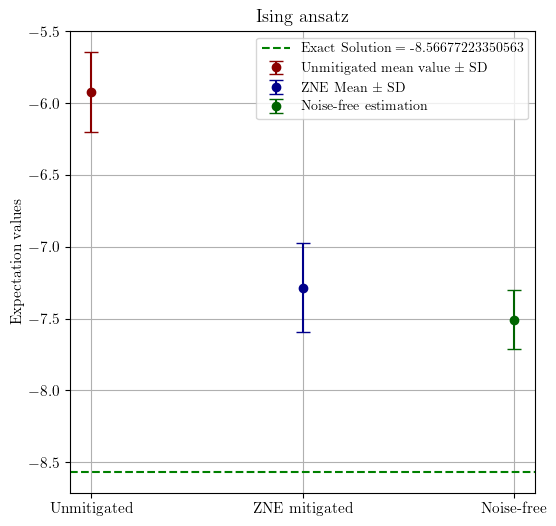

In [11]:
# Data labels
labels = ["Unmitigated", "ZNE mitigated", "Noise-free"]

# Values to plot
means = [unmitigated_eigen_vals_mean, zne_mean, noisefree_mean]
sds = [unmitigated_eigen_vals_sd, zne_sd, noisefree_sd]

# Create the plot with error bars
plt.figure(figsize=(6, 6))

# Unmitigated
plt.errorbar(labels[0], means[0], yerr=sds[0], fmt="o", color=plot_color[1], capsize=5, label="Unmitigated mean value ± SD")

# ZNE
plt.errorbar(labels[1], means[1], yerr=sds[1], fmt="o", color=plot_color[2], capsize=5, label="ZNE Mean ± SD")

# Noise-free
plt.errorbar(labels[2], means[2], yerr=sds[2], fmt="o", color=plot_color[3], capsize=5, label="Noise-free estimation")

# Exact solution
plt.axhline(y=exact_sol, color=plot_color[0], linestyle="--", label=f"Exact Solution = {exact_sol}")

# Adding title and labels
plt.title(plot_titles[0])
plt.ylabel("Expectation values")
plt.grid(True)
# Add a legend
plt.legend()
plt.show()

### (B) Expectation value vs noise-level plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


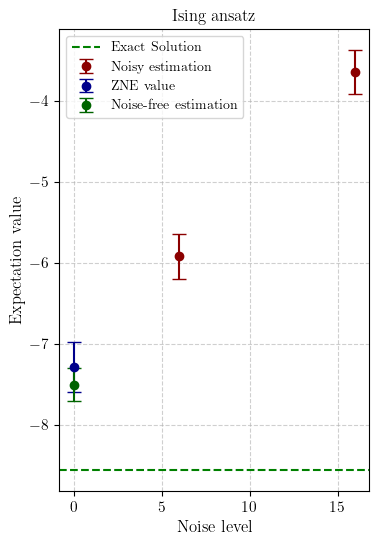

In [12]:
# Extrapolated value
extrapolated_noise = 0  # Zero noise limit

# Plot size
plt.figure(figsize=(4, 6))

# Noisy
plt.errorbar(
    noise_level, 
    [unmitigated_eigen_vals_mean, boosted_noisy_expectation_val_mean], 
    yerr=[unmitigated_eigen_vals_sd, boosted_noisy_expectation_val_sd], 
    fmt="o", 
    ecolor=plot_color[1],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_color[1]
)
# Extrapolated
plt.errorbar(
    extrapolated_noise, 
    zne_mean, 
    yerr=zne_sd, 
    fmt="o", 
    ecolor=plot_color[2],
    capsize=5, 
    label="ZNE value", 
    color=plot_color[2]
)
# Noise-free 
plt.errorbar(
    0, 
    noisefree_mean, 
    yerr=noisefree_sd, 
    fmt="o", 
    ecolor=plot_color[3],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_color[3]
)
# Exact solution
plt.axhline(y=exact_sol, color=plot_color[0], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel("Noise level", fontsize=12)
plt.ylabel("Expectation value", fontsize=12)
plt.title(plot_titles[0], fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
# Save as eps
plt.savefig('noisefree_ising.eps', format='eps')
plt.show()


---

## Tabulation of Experimental Data

**WARNING:** _The following content may not be viewed properly on GitHub. It is recommended to download the notebook and open it with VSCode to properly view the tabulation._

**NOTE:** _The values of coefficients `cn`, `bn`, and `r` in the following table are those provided in the configuration file, but their values could be overwritten depending on the target observable type or ansatz type._


#### Unmitigated VQE data

In [13]:
# Normalize/Flatten JSON and convert it into a DataFrame
df = pd.json_normalize(vqe_data)
print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))

+--------------+------------------+----------------+-------------------------+-------------------------------------+-------------------------------------+------------------------------------+----------------------------------+-----------------------------+------------------------------+---------------------------+------------------------+----------------------------------+-------------------------------------+--------------------------------------+--------------------------+---------------------------+-----------------------------+-------------------------------------------+-------------------------------------------+------------------------------------------+------------------------------------+------------------------------------+----------------------------------+---------------------------------+--------------------------------+----------------------------------------------------------------------------------------------------+---------------------+---------------------+-----------

#### ZNE data

In [14]:
df = pd.json_normalize(all_zne_data)
print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))

+--------------+------------------+----------------+-------------------------+-------------------------------------+-------------------------------------+------------------------------------+---------------------------------------------------+-----------------------------+------------------------------+---------------------------+------------------------+----------------------------------+-------------------------------------+--------------------------------------+--------------------------+---------------------------+-----------------------------+-------------------------------------------+-------------------------------------------+------------------------------------------+------------------------------------+------------------------------------+----------------------------------+---------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Noise-free ansatz data

In [15]:
df = pd.json_normalize(noise_free_data)
print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))

+--------------+------------------+----------------+-------------------------+-------------------------------------+-------------------------------------+------------------------------------+----------------------------------+-----------------------------+------------------------------+---------------------------+------------------------+----------------------------------+-------------------------------------+--------------------------------------+--------------------------+---------------------------+-----------------------------+-------------------------------------------+-------------------------------------------+------------------------------------------+------------------------------------+------------------------------------+----------------------------------+---------------------------------+--------------------------------+---------------------------+---------------------+---------------------+-----------------------+--------------------------+--------------------+------------